In [8]:
from espei.parameter_selection.fitting_descriptions import ModelFittingDescription, elastic_fitting_description, ElasticModel, molar_volume_fit_desc
from espei.parameter_selection.utils import _get_sample_condition_dicts
from espei.error_functions.non_equilibrium_thermochemical_error import get_prop_samples
from espei.parameter_selection.selection import select_model
from espei.sublattice_tools import tuplify
from espei.parameter_selection.model_building import build_redlich_kister_candidate_models
from espei.paramselect import _build_feature_matrix, has_symbol
from espei.core_utils import filter_configurations, filter_temperatures
from symengine import Symbol

def fit_model_x(model_fitting_description: ModelFittingDescription, datasets, dbf, aicc_penalty_factor=1.0):
    for fitting_step in model_fitting_description.fitting_steps:
        # TODO: hardcoded
        comps = datasets[0]["components"] + ["VA"]
        phase = datasets[0]["phases"][0]
        fixed_model = model_fitting_description.model(dbf, comps, phase)
        print("fitting_step", fitting_step)
        desired_data = [ds for ds in datasets if any(ds["output"].startswith(dtype) for dtype in fitting_step.data_types_read)] # TODO: proper query datasets for matches
        # configuration = [["TA", "W"]]  # maybe needs to be canonical? not sure
        configuration = datasets[0]["solver"]["sublattice_configurations"][0]  # maybe needs to be canonical? not sure
        symmetry = None
        desired_data = filter_configurations(desired_data, configuration, symmetry)
        # print("filter_configurations", desired_data)
        desired_data = filter_temperatures(desired_data)
        # print("filter_temperatures", desired_data)
        if len(desired_data) == 0:
            print("exiting with no data")
            # early exit, nothing to do with our data
            return  # TODO: match expected return type

        config_tup = tuple(map(tuplify, configuration))
        calculate_dict = get_prop_samples(desired_data, config_tup)
        # print("calculate_dict", calculate_dict)
        sample_condition_dicts = _get_sample_condition_dicts(calculate_dict, config_tup, fixed_model.phase_name)
        # print("sample_condition_dicts", sample_condition_dicts)
        # We assume all properties in the same fitting step have the same
        # features (all CPM, all HM, etc., but different ref states).
        # data quantities are the same for each candidate model and can be computed up front
        # TODO: support that we can possibly have multiple data types per feature type
        fixed_portions = []  # TODO: we need to support the fact that there's fixed_portions from earlier fitting steps. e.g. VA has a V0 fixed portion
        # print("desired_data", desired_data)
        regression_rhs = fitting_step.get_data_quantities(fitting_step.data_types_read[0], fixed_model, fixed_portions, desired_data, sample_condition_dicts)
        # print("data_qtys", data_qtys)

        candidate_models = []
        # Transform param-only features to parameter+RK features
        feature_sets = build_redlich_kister_candidate_models(config_tup, fitting_step.get_feature_sets())
        for features in feature_sets:
            feature_matrix = _build_feature_matrix(sample_condition_dicts, list(map(fitting_step.transform_feature, features)))
            # print("symbolic_coefficients", list(map(fitting_step.transform_feature, features)))
            # print("feature_matrix", feature_matrix)
            candidate_model = (features, feature_matrix, regression_rhs)
            # print("features", features)
            # print("candidate_model", candidate_model)
            # TODO: maybe need to substitite our sample condition dicts manually somewhere if the site fractions didn't get subbed properly. TBD
            candidate_models.append(candidate_model)
            # coeffs = fit_model(feature_matrix, data_quantities, 1e-100)
            # print(features)
        # print('candidate_models', candidate_models)
        selected_features, selected_coeffs = select_model(candidate_models, 1e-100, 1.0, aicc_factor=aicc_penalty_factor)
        # print("selected_features", selected_features, selected_coeffs)

        # TODO: parameters are entered here, but added directly without going
        # through a function that names them VV#### so they can be fit later.
        # We add the parameters to address cases where lower order terms are fit
        # (e.g. V0 fitting step that affects the VA fitting step).
        # Probably this was the concept that fixed_portions tried to address,
        # but this seems more "pycalphadic" (although possibly more expensive
        # because we need to reconstruct models every iteration).
        # I also think it probably makes the code more complex to use a
        # fixed_portions method in the general case (where there can be lots of
        # steps and different parameter types - that worked well for Gibbs
        # energy where fixed portions were higher order derivatives of the
        # same parameter type).
        for coeff, feat in zip(selected_coeffs, selected_features):
            param = coeff*feat.subs({Symbol("YS"): 1.0, Symbol("Z"): 1.0})
            # extract parameter order
            parameter_order = 0
            # we do reversed to prevent false identification of high order orders as low order
            # e.g. has_symbol(YS*Z) will be true if the expr contains YS*Z**2.
            # there may be some clever workaround, but this code isn't fully featured
            for degree in reversed(range(10)):
                check_symbol = Symbol('YS') * Symbol('Z')**degree
                if has_symbol(feat, check_symbol):
                    parameter_order = degree
                    break
            print(f"Adding {fitting_step.parameter_name} parameters to {fixed_model.phase_name} {tuple(map(tuplify, configuration))} order={parameter_order} {param}")
            dbf.add_parameter(fitting_step.parameter_name, fixed_model.phase_name, tuple(map(tuplify, configuration)), parameter_order, param)


In [9]:
# Elastic fitting
from pycalphad import Database, Model

db_elastic = Database("""
 ELEMENT VA   VACUUM 0.0000E+00  0.0000E+00  0.0000E+00!
 ELEMENT TI   BCC_A2 0.0000E+00  0.0000E+00  0.0000E+00 !
 ELEMENT MO   BCT_A5 0.0000E+00  0.0000E+00  0.0000E+00 !
 ELEMENT NB   BCC_A2 0.0000E+00  0.0000E+00  0.0000E+00 !
 ELEMENT SN   BCT_A5 0.0000E+00  0.0000E+00  0.0000E+00 !
 ELEMENT TA   BCC_A2 0.0000E+00  0.0000E+00  0.0000E+00 !
 ELEMENT ZR   BCT_A5 0.0000E+00  0.0000E+00  0.0000E+00 !

 TYPE_DEFINITION % SEQ *!
 DEFINE_SYSTEM_DEFAULT ELEMENT 6 !
 DEFAULT_COMMAND DEF_SYS_ELEMENT VA !

 TYPE_DEFINITION & GES A_P_D BCC_A2 MAGNETIC  -1.0    4.00000E-01 !
 PHASE BCC_A2  %&  2 1   3 !
    CONSTITUENT BCC_A2  :TI,MO,NB,SN,TA,ZR : VA :  !
""")


# Data digitized from Marker et al., Com. Mat. Sci. 142 (2018) 215-226.
datasets_Ti = [
    {
        "components": ["TI"],
        "phases": ["BCC_A2"],
        "output": "C11",
        "values": [[[93]]],
        "conditions": {"T": 298.15, "P": 101325},
        "solver": {"sublattice_site_ratios": [1, 3], "sublattice_configurations": [[["TI"], ["VA"]]], "sublattice_occupancies": [[[1.0], [1.0]]]},
        "reference": "Marker (2018)",
        "bibtex": "marker2018binary_elastic",
        "comment": "Values pulled from Table 4 (DFT calculations).",
        "tags": []
    },
    {
        "components": ["TI"],
        "phases": ["BCC_A2"],
        "output": "C12",
        "values": [[[115]]],
        "conditions": {"T": 298.15, "P": 101325},
        "solver": {"sublattice_site_ratios": [1, 3], "sublattice_configurations": [[["TI"], ["VA"]]], "sublattice_occupancies": [[[1.0], [1.0]]]},
        "reference": "Marker (2018)",
        "bibtex": "marker2018binary_elastic",
        "comment": "Values pulled from Table 4 (DFT calculations).",
        "tags": []
    },
    {
        "components": ["TI"],
        "phases": ["BCC_A2"],
        "output": "C44",
        "values": [[[41]]],
        "conditions": {"T": 298.15, "P": 101325},
        "solver": {"sublattice_site_ratios": [1, 3], "sublattice_configurations": [[["TI"], ["VA"]]], "sublattice_occupancies": [[[1.0], [1.0]]]},
        "reference": "Marker (2018)",
        "bibtex": "marker2018binary_elastic",
        "comment": "Values pulled from Table 4 (DFT calculations).",
        "tags": []
    },
]

fit_model_x(elastic_fitting_description, datasets_Ti, db_elastic)  # parameter added automatically


datasets_Mo = [
    {
        "components": ["MO"],
        "phases": ["BCC_A2"],
        "output": "C11",
        "values": [[[475]]],
        "conditions": {"T": 298.15, "P": 101325},
        "solver": {"sublattice_site_ratios": [1, 3], "sublattice_configurations": [[["MO"], ["VA"]]], "sublattice_occupancies": [[[1.0], [1.0]]]},
        "reference": "Marker (2018)",
        "bibtex": "marker2018binary_elastic",
        "comment": "Values pulled from Table 4 (DFT calculations).",
        "tags": []
    },
    {
        "components": ["MO"],
        "phases": ["BCC_A2"],
        "output": "C12",
        "values": [[[164]]],
        "conditions": {"T": 298.15, "P": 101325},
        "solver": {"sublattice_site_ratios": [1, 3], "sublattice_configurations": [[["MO"], ["VA"]]], "sublattice_occupancies": [[[1.0], [1.0]]]},
        "reference": "Marker (2018)",
        "bibtex": "marker2018binary_elastic",
        "comment": "Values pulled from Table 4 (DFT calculations).",
        "tags": []
    },
    {
        "components": ["MO"],
        "phases": ["BCC_A2"],
        "output": "C44",
        "values": [[[108]]],
        "conditions": {"T": 298.15, "P": 101325},
        "solver": {"sublattice_site_ratios": [1, 3], "sublattice_configurations": [[["MO"], ["VA"]]], "sublattice_occupancies": [[[1.0], [1.0]]]},
        "reference": "Marker (2018)",
        "bibtex": "marker2018binary_elastic",
        "comment": "Values pulled from Table 4 (DFT calculations).",
        "tags": []
    },
]
fit_model_x(elastic_fitting_description, datasets_Mo, db_elastic)  # parameter added automatically

datasets_Sn = [
    {
        "components": ["SN"],
        "phases": ["BCC_A2"],
        "output": "C11",
        "values": [[[50]]],
        "conditions": {"T": 298.15, "P": 101325},
        "solver": {"sublattice_site_ratios": [1, 3], "sublattice_configurations": [[["SN"], ["VA"]]], "sublattice_occupancies": [[[1.0], [1.0]]]},
        "reference": "Marker (2018)",
        "bibtex": "marker2018binary_elastic",
        "comment": "Values pulled from Table 4 (DFT calculations).",
        "tags": []
    },
    {
        "components": ["SN"],
        "phases": ["BCC_A2"],
        "output": "C12",
        "values": [[[52]]],
        "conditions": {"T": 298.15, "P": 101325},
        "solver": {"sublattice_site_ratios": [1, 3], "sublattice_configurations": [[["SN"], ["VA"]]], "sublattice_occupancies": [[[1.0], [1.0]]]},
        "reference": "Marker (2018)",
        "bibtex": "marker2018binary_elastic",
        "comment": "Values pulled from Table 4 (DFT calculations).",
        "tags": []
    },
    {
        "components": ["SN"],
        "phases": ["BCC_A2"],
        "output": "C44",
        "values": [[[29]]],
        "conditions": {"T": 298.15, "P": 101325},
        "solver": {"sublattice_site_ratios": [1, 3], "sublattice_configurations": [[["SN"], ["VA"]]], "sublattice_occupancies": [[[1.0], [1.0]]]},
        "reference": "Marker (2018)",
        "bibtex": "marker2018binary_elastic",
        "comment": "Values pulled from Table 4 (DFT calculations).",
        "tags": []
    },
]
fit_model_x(elastic_fitting_description, datasets_Sn, db_elastic)  # parameter added automatically



datasets_TiMo = [
    {
        "components": ["MO", "TI"],
        "phases": ["BCC_A2"],
        "output": "C11",
        "values": [[[124, 146, 178, 268, 385, 451, 464]]],
        "conditions": {"T": 298.15, "P": 101325},
        "solver": {"sublattice_site_ratios": [1, 3], "sublattice_configurations": [[["MO", "TI"], ["VA"]], [["MO", "TI"], ["VA"]], [["MO", "TI"], ["VA"]], [["MO", "TI"], ["VA"]], [["MO", "TI"], ["VA"]], [["MO", "TI"], ["VA"]], [["MO", "TI"], ["VA"]]], "sublattice_occupancies": [[[0.06, 0.94], [1.0]], [[0.13, 0.87], [1.0]], [[0.25, 0.75], [1.0]], [[0.50, 0.50], [1.0]], [[0.75, 0.25], [1.0]], [[0.94, 0.06], [1.0]], [[0.98, 0.02], [1.0]]]},
        "reference": "Marker (2018)",
        "bibtex": "marker2018binary_elastic",
        "comment": "Values pulled from Table 4 (DFT calculations).",
        "tags": []
    },
    {
        "components": ["MO", "TI"],
        "phases": ["BCC_A2"],
        "output": "C12",
        "values": [[[111, 113, 123, 136, 146, 158, 163]]],
        "conditions": {"T": 298.15, "P": 101325},
        "solver": {"sublattice_site_ratios": [1, 3], "sublattice_configurations": [[["MO", "TI"], ["VA"]], [["MO", "TI"], ["VA"]], [["MO", "TI"], ["VA"]], [["MO", "TI"], ["VA"]], [["MO", "TI"], ["VA"]], [["MO", "TI"], ["VA"]], [["MO", "TI"], ["VA"]]], "sublattice_occupancies": [[[0.06, 0.94], [1.0]], [[0.13, 0.87], [1.0]], [[0.25, 0.75], [1.0]], [[0.50, 0.50], [1.0]], [[0.75, 0.25], [1.0]], [[0.94, 0.06], [1.0]], [[0.98, 0.02], [1.0]]]},
        "reference": "Marker (2018)",
        "bibtex": "marker2018binary_elastic",
        "comment": "Values pulled from Table 4 (DFT calculations).",
        "tags": []
    },
    {
        "components": ["MO", "TI"],
        "phases": ["BCC_A2"],
        "output": "C44",
        "values": [[[38, 29, 32, 42, 66, 96, 100]]],
        "conditions": {"T": 298.15, "P": 101325},
        "solver": {"sublattice_site_ratios": [1, 3], "sublattice_configurations": [[["MO", "TI"], ["VA"]], [["MO", "TI"], ["VA"]], [["MO", "TI"], ["VA"]], [["MO", "TI"], ["VA"]], [["MO", "TI"], ["VA"]], [["MO", "TI"], ["VA"]], [["MO", "TI"], ["VA"]]], "sublattice_occupancies": [[[0.06, 0.94], [1.0]], [[0.13, 0.87], [1.0]], [[0.25, 0.75], [1.0]], [[0.50, 0.50], [1.0]], [[0.75, 0.25], [1.0]], [[0.94, 0.06], [1.0]], [[0.98, 0.02], [1.0]]]},
        "reference": "Marker (2018)",
        "bibtex": "marker2018binary_elastic",
        "comment": "Values pulled from Table 4 (DFT calculations).",
        "tags": []
    },
]

fit_model_x(elastic_fitting_description, datasets_TiMo, db_elastic)  # parameter added automatically


datasets_TiSn = [
    {
        "components": ["SN", "TI"],
        "phases": ["BCC_A2"],
        "output": "C11",
        "values": [[[100, 105, 88, 92]]],
        "conditions": {"T": 298.15, "P": 101325},
        "solver": {"sublattice_site_ratios": [1, 3], "sublattice_configurations": [[["SN", "TI"], ["VA"]], [["SN", "TI"], ["VA"]], [["SN", "TI"], ["VA"]], [["SN", "TI"], ["VA"]]], "sublattice_occupancies": [[[0.06, 0.94], [1.0]], [[0.25, 0.75], [1.0]], [[0.50, 0.50], [1.0]], [[0.75, 0.25], [1.0]]]},
        "reference": "Marker (2018)",
        "bibtex": "marker2018binary_elastic",
        "comment": "Values pulled from Table 4 (DFT calculations).",
        "tags": []
    },
    {
        "components": ["SN", "TI"],
        "phases": ["BCC_A2"],
        "output": "C12",
        "values": [[[122, 114, 93, 55]]],
        "conditions": {"T": 298.15, "P": 101325},
        "solver": {"sublattice_site_ratios": [1, 3], "sublattice_configurations": [[["SN", "TI"], ["VA"]], [["SN", "TI"], ["VA"]], [["SN", "TI"], ["VA"]], [["SN", "TI"], ["VA"]]], "sublattice_occupancies": [[[0.06, 0.94], [1.0]], [[0.25, 0.75], [1.0]], [[0.50, 0.50], [1.0]], [[0.75, 0.25], [1.0]]]},
        "reference": "Marker (2018)",
        "bibtex": "marker2018binary_elastic",
        "comment": "Values pulled from Table 4 (DFT calculations).",
        "tags": []
    },
    {
        "components": ["SN", "TI"],
        "phases": ["BCC_A2"],
        "output": "C44",
        "values": [[[46, 60, 46, 35]]],
        "conditions": {"T": 298.15, "P": 101325},
        "solver": {"sublattice_site_ratios": [1, 3], "sublattice_configurations": [[["SN", "TI"], ["VA"]], [["SN", "TI"], ["VA"]], [["SN", "TI"], ["VA"]], [["SN", "TI"], ["VA"]]], "sublattice_occupancies": [[[0.06, 0.94], [1.0]], [[0.25, 0.75], [1.0]], [[0.50, 0.50], [1.0]], [[0.75, 0.25], [1.0]]]},
        "reference": "Marker (2018)",
        "bibtex": "marker2018binary_elastic",
        "comment": "Values pulled from Table 4 (DFT calculations).",
        "tags": []
    },
]
fit_model_x(elastic_fitting_description, datasets_TiSn, db_elastic, 1.115)


fitting_step <class 'espei.parameter_selection.fitting_steps.StepElasticC11'>
Adding C11 parameters to BCC_A2 (('TI',), ('VA',)) order=0 93.0
fitting_step <class 'espei.parameter_selection.fitting_steps.StepElasticC12'>
Adding C12 parameters to BCC_A2 (('TI',), ('VA',)) order=0 115.0
fitting_step <class 'espei.parameter_selection.fitting_steps.StepElasticC44'>
Adding C44 parameters to BCC_A2 (('TI',), ('VA',)) order=0 41.0
fitting_step <class 'espei.parameter_selection.fitting_steps.StepElasticC11'>
Adding C11 parameters to BCC_A2 (('MO',), ('VA',)) order=0 475.0
fitting_step <class 'espei.parameter_selection.fitting_steps.StepElasticC12'>
Adding C12 parameters to BCC_A2 (('MO',), ('VA',)) order=0 164.0
fitting_step <class 'espei.parameter_selection.fitting_steps.StepElasticC44'>
Adding C44 parameters to BCC_A2 (('MO',), ('VA',)) order=0 108.0
fitting_step <class 'espei.parameter_selection.fitting_steps.StepElasticC11'>
Adding C11 parameters to BCC_A2 (('SN',), ('VA',)) order=0 50.0
fi

(0.0, 70.0)

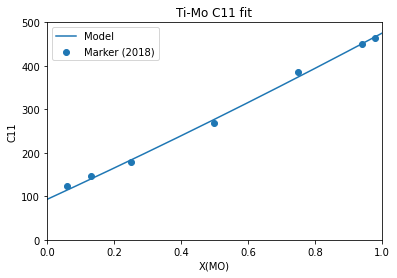

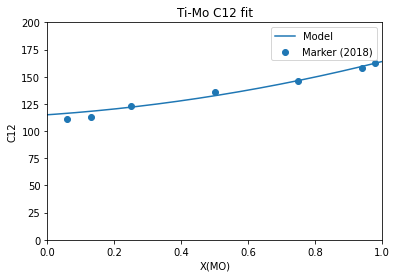

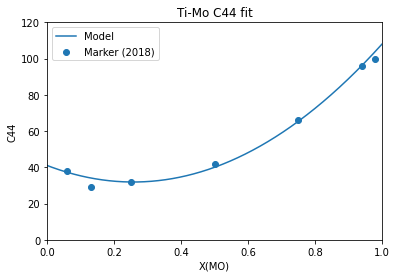

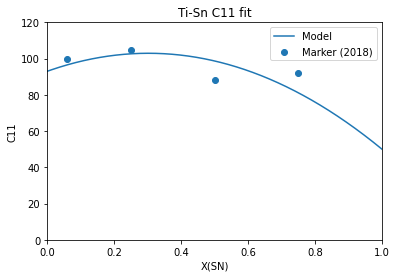

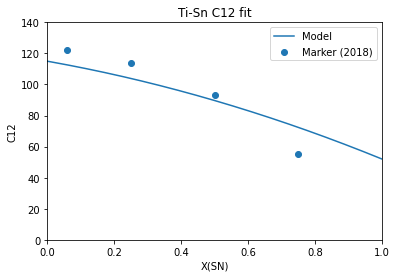

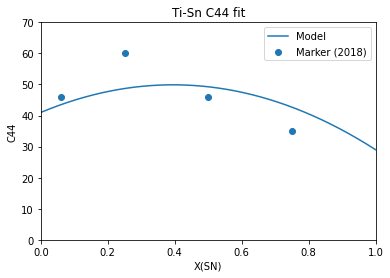

In [10]:
import matplotlib.pyplot as plt
import numpy as np
from symengine import lambdify
from pycalphad import variables as v
# Ti-Mo
#######
mod_el = ElasticModel(db_elastic, ["TI", "MO", "VA"], "BCC_A2")

x_TI = np.linspace(0, 1, 1001)
x_MO = 1 - x_TI
x_MO_TI_VA = np.empty((x_TI.shape[-1], 3))
x_MO_TI_VA[:, 0] = x_MO
x_MO_TI_VA[:, 1] = x_TI
x_MO_TI_VA[:, 2] = np.ones_like(x_TI)
func_MO_TI_C11 = lambdify([v.Y("BCC_A2", 0, "MO"), v.Y("BCC_A2", 0, "TI"), v.Y("BCC_A2", 1, "VA")], [mod_el.C11])
func_MO_TI_C12 = lambdify([v.Y("BCC_A2", 0, "MO"), v.Y("BCC_A2", 0, "TI"), v.Y("BCC_A2", 1, "VA")], [mod_el.C12])
func_MO_TI_C44 = lambdify([v.Y("BCC_A2", 0, "MO"), v.Y("BCC_A2", 0, "TI"), v.Y("BCC_A2", 1, "VA")], [mod_el.C44])
# get data
x_MO_data = [occu[0][0] for occu in datasets_TiMo[0]["solver"]["sublattice_occupancies"]]
C11_data = np.asarray(datasets_TiMo[0]["values"]).squeeze()
C12_data = np.asarray(datasets_TiMo[1]["values"]).squeeze()
C44_data = np.asarray(datasets_TiMo[2]["values"]).squeeze()

# Plot
plt.title("Ti-Mo C11 fit")
plt.plot(x_MO, func_MO_TI_C11(x_MO_TI_VA), label="Model")
plt.scatter(x_MO_data, C11_data, label='Marker (2018)')
plt.legend()
plt.xlabel("X(MO)")
plt.ylabel("C11")
plt.xlim(0, 1)
plt.ylim(0, 500)

plt.figure()
plt.title("Ti-Mo C12 fit")
plt.plot(x_MO, func_MO_TI_C12(x_MO_TI_VA), label="Model")
plt.scatter(x_MO_data, C12_data, label='Marker (2018)')
plt.legend()
plt.xlabel("X(MO)")
plt.ylabel("C12")
plt.xlim(0, 1)
plt.ylim(0, 200)

plt.figure()
plt.title("Ti-Mo C44 fit")
plt.plot(x_MO, func_MO_TI_C44(x_MO_TI_VA), label="Model")
plt.scatter(x_MO_data, C44_data, label='Marker (2018)')
plt.legend()
plt.xlabel("X(MO)")
plt.ylabel("C44")
plt.xlim(0, 1)
plt.ylim(0, 120)


# Ti-Sn
#######
mod_el = ElasticModel(db_elastic, ["TI", "SN", "VA"], "BCC_A2")

x_TI = np.linspace(0, 1, 1001)
x_SN = 1 - x_TI
x_SN_TI_VA = np.empty((x_TI.shape[-1], 3))
x_SN_TI_VA[:, 0] = x_SN
x_SN_TI_VA[:, 1] = x_TI
x_SN_TI_VA[:, 2] = np.ones_like(x_TI)
func_SN_TI_C11 = lambdify([v.Y("BCC_A2", 0, "SN"), v.Y("BCC_A2", 0, "TI"), v.Y("BCC_A2", 1, "VA")], [mod_el.C11])
func_SN_TI_C12 = lambdify([v.Y("BCC_A2", 0, "SN"), v.Y("BCC_A2", 0, "TI"), v.Y("BCC_A2", 1, "VA")], [mod_el.C12])
func_SN_TI_C44 = lambdify([v.Y("BCC_A2", 0, "SN"), v.Y("BCC_A2", 0, "TI"), v.Y("BCC_A2", 1, "VA")], [mod_el.C44])
# get data
x_SN_data = [occu[0][0] for occu in datasets_TiSn[0]["solver"]["sublattice_occupancies"]]
C11_data = np.asarray(datasets_TiSn[0]["values"]).squeeze()
C12_data = np.asarray(datasets_TiSn[1]["values"]).squeeze()
C44_data = np.asarray(datasets_TiSn[2]["values"]).squeeze()

# Plot
plt.figure()
plt.title("Ti-Sn C11 fit")
plt.plot(x_SN, func_SN_TI_C11(x_SN_TI_VA), label="Model")
plt.scatter(x_SN_data, C11_data, label='Marker (2018)')
plt.legend()
plt.xlabel("X(SN)")
plt.ylabel("C11")
plt.xlim(0, 1)
plt.ylim(0, 120)

plt.figure()
plt.title("Ti-Sn C12 fit")
plt.plot(x_SN, func_SN_TI_C12(x_SN_TI_VA), label="Model")
plt.scatter(x_SN_data, C12_data, label='Marker (2018)')
plt.legend()
plt.xlabel("X(SN)")
plt.ylabel("C12")
plt.xlim(0, 1)
plt.ylim(0, 140)

plt.figure()
plt.title("Ti-Sn C44 fit")
plt.plot(x_SN, func_SN_TI_C44(x_SN_TI_VA), label="Model")
plt.scatter(x_SN_data, C44_data, label='Marker (2018)')
plt.legend()
plt.xlabel("X(SN)")
plt.ylabel("C44")
plt.xlim(0, 1)
plt.ylim(0, 70)


fitting_step <class 'espei.parameter_selection.fitting_steps.StepV0'>
Adding V0 parameters to BCC_A2 (('TA', 'W'),) order=0 -4.00189999999996e-07
fitting_step <class 'espei.parameter_selection.fitting_steps.StepLogVA'>
Adding VA parameters to BCC_A2 (('TA', 'W'),) order=0 -0.000132797426989401*T
[1.07870000e-05 1.04002492e-05 1.00448925e-05 9.76045653e-06
 9.50330000e-06]
data_1pt_VM 9.997209252001686e-06


(0.0, 1.0)

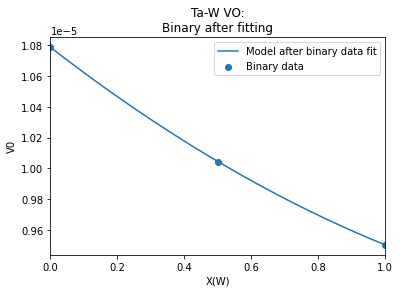

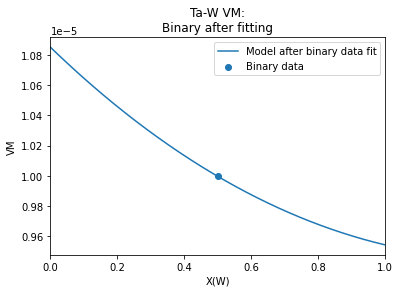

In [11]:
# VA binary fitting
# For fitting VA, we might need to be careful about how we're using shift_reference_state
# I think we need to shift_reference_state to always use real volumes so we
# don't get trapped trying to do the log on a negative (excess) volume when we
# do the linearization
# Q: is it a viable alternative if we treat all excess volumes as positive and adjust the sign later?

datasets = [
    # dummy dataset for 50/50 composition, eventually these should be real ESPEI datasets
    {
        "components": ["TA", "W"],
        "phases": ["BCC_A2"],
        "output": "V0",
        "values": [[[1.00448925e-05]]],  # "fixed" value (absolute value from mix data with calphd reference state) extracted manually from above
        "conditions": {"T": 298.15, "P": 101325},
        "solver": {"sublattice_site_ratios": [1], "sublattice_configurations": [[["TA", "W"]]], "sublattice_occupancies": [[[0.5, 0.5]]]},
        "reference": "VASP (LLNL)",
        "bibtex": "UNPUBLISHED",
        "comment": "Brandon Bocklund DFT calculations. VASP, PBEsol, PAW 400 eV cutoff, 0.2 KSPACING",
        "tags": ["non-equilibrium-thermochemical", "LLNL-proprietary"]
    },
    # 1 point VA
    # {
    #     "components": ["TA", "W"],
    #     "phases": ["BCC_A2"],
    #     "output": "VM",
    #     "values": [[[9.997209252001686e-06]]],  # "fixed" value (absolute value from mix data with calphd reference state) extracted manually from above
    #     "conditions": {"T": 298.15, "P": 101325},
    #     "solver": {"sublattice_site_ratios": [1], "sublattice_configurations": [[["TA", "W"]]], "sublattice_occupancies": [[[0.5, 0.5]]]},
    #     "reference": "VASP (LLNL)",
    #     "bibtex": "UNPUBLISHED",
    #     "comment": "Brandon Bocklund DFT calculations. VASP, PBEsol, PAW 400 eV cutoff, 0.2 KSPACING",
    #     "tags": ["non-equilibrium-thermochemical", "LLNL-proprietary"]
    # },
    # 1 point VA, using mixing reference state
    {
        "components": ["TA", "W"],
        "phases": ["BCC_A2"],
        "output": "VM_MIX",
        "values": [[[-2e-7]]],
        "conditions": {"T": 298.15, "P": 101325},
        "solver": {"sublattice_site_ratios": [1], "sublattice_configurations": [[["TA", "W"]]], "sublattice_occupancies": [[[0.5, 0.5]]]},
        "reference": "VASP (LLNL)",
        "bibtex": "UNPUBLISHED",
        "comment": "Brandon Bocklund DFT calculations. VASP, PBEsol, PAW 400 eV cutoff, 0.2 KSPACING",
        "tags": ["non-equilibrium-thermochemical", "LLNL-proprietary"]
    },
    # 3 point VA
    # mix vals:      +1.0e-7  -2e-7   -4e-7
    # concrete vals: 1.0623878723285703e-05, 9.997209252001686e-06, 9.47053978071767e-06
    # {
    #     "components": ["TA", "W"],
    #     "phases": ["BCC_A2"],
    #     "output": "VM",
    #     "values": [[[1.0623878723285703e-05, 9.997209252001686e-06, 9.47053978071767e-06]]],  # "fixed" value (absolute value from mix data with calphd reference state) extracted manually from above
    #     "conditions": {"T": 298.15, "P": 101325},
    #     "solver": {"sublattice_site_ratios": [1], "sublattice_configurations": [[["TA", "W"]], [["TA", "W"]], [["TA", "W"]]], "sublattice_occupancies": [[[0.75, 0.25]], [[0.5, 0.5]], [[0.25, 0.75]]]},
    #     "reference": "VASP (LLNL)",
    #     "bibtex": "UNPUBLISHED",
    #     "comment": "Brandon Bocklund DFT calculations. VASP, PBEsol, PAW 400 eV cutoff, 0.2 KSPACING",
    #     "tags": ["non-equilibrium-thermochemical", "LLNL-proprietary"]
    # },
]
dbf = Database("lu2005-volumes.tdb")
mod = Model(dbf, ["TA", "W"], "BCC_A2")

fit_model_x(molar_volume_fit_desc, datasets, dbf)  # parameter added automatically

# important, do not reload the database because we just added a new parameter!
mod = Model(dbf, ["TA", "W"], "BCC_A2")

x_TA = np.linspace(0, 1, 1001)
x_W = 1-x_TA
x_TA_W = np.empty((x_TA.shape[-1], 2))
x_TA_W[:, 0] = x_TA
x_TA_W[:, 1] = x_W
func_V0_TA_W = lambdify([v.Y("BCC_A2", 0, "TA"), v.Y("BCC_A2", 0, "W")], [mod.V0])
func_VM_TA_W = lambdify([v.Y("BCC_A2", 0, "TA"), v.Y("BCC_A2", 0, "W")], [mod.VM.subs({v.T: 298.15})])

v0_calphad = {  # these were extracted "by hand" from the print output above
    "CR": 7.0403e-06,
    "FE": 7.0079e-06,
    "MO": 9.3461e-06,
    "NB": 1.0752e-05,
    "TA": 1.0787e-05,
    "TI": 1.0592e-05,
    "V": 8.2481e-06,
    "W": 9.5033e-06,
    "ZR": 1.3812e-05,
}

# raw V0s from DFT
data_5pt_x_W = np.asarray([0, 0.25, 0.50, 0.75, 1.0])
data_5pt_V0 = np.asarray([1.0648e-05, 1.0287174212562773e-05, 9.957742546823015e-06, 9.699231530816361e-06, 9.468e-06])

# fix the reference state to match calphad
#                     V0             DFT V0_Ta * x_TA              +      DFT V0_W * x_W
# mixing reference state
data_5pt_V0_mix = data_5pt_V0 - (data_5pt_V0[0]*(1-data_5pt_x_W) + data_5pt_V0[-1]*(data_5pt_x_W))
# absolute values of Calphad unary + DFT_MIX binary
#                Calphad V0_Ta * x_TA               +       Calphad V0_W * x_W       +  DFT V0 MIX
data_5pt_V0_fix = v0_calphad["TA"]*(1-data_5pt_x_W) + v0_calphad["W"]*(data_5pt_x_W) + data_5pt_V0_mix
print(data_5pt_V0_fix)

data_1pt_x_W = data_5pt_x_W[[0,2,4]]
data_1pt_V0 = data_5pt_V0_fix[[0,2,4]]

plt.title("Ta-W VO:\nBinary after fitting")
plt.plot(x_W, func_V0_TA_W(x_TA_W), label="Model after binary data fit")
plt.scatter(data_1pt_x_W, data_1pt_V0, label='Binary data')
plt.legend()
plt.xlabel("X(W)")
plt.ylabel("V0")
plt.xlim(0, 1)

plt.figure()

plt.title("Ta-W VM:\nBinary after fitting")
plt.plot(x_W, func_VM_TA_W(x_TA_W), label="Model after binary data fit")
data_1pt_VM = -2.0e-7 + (func_VM_TA_W([1, 0])*0.5 + func_VM_TA_W([0, 1])*0.5)
data_3pt_VM = [
    +1.0e-7 + (func_VM_TA_W([1, 0])*0.75 + func_VM_TA_W([0, 1])*0.25),
    -2.0e-7 + (func_VM_TA_W([1, 0])*0.50 + func_VM_TA_W([0, 1])*0.50),
    -4.0e-7 + (func_VM_TA_W([1, 0])*0.25 + func_VM_TA_W([0, 1])*0.75),
]
print("data_1pt_VM", data_1pt_VM)
plt.scatter([0.5], data_1pt_VM, label='Binary data')
# print("data_3pt_VM", data_3pt_VM)
# plt.scatter([0.25, 0.5, 0.75], data_3pt_VM, label='Binary data')
plt.legend()
plt.xlabel("X(W)")
plt.ylabel("VM")
plt.xlim(0, 1)

fitting_step <class 'espei.parameter_selection.fitting_steps.StepV0'>
Adding V0 parameters to BCC_A2 (('TA', 'W'),) order=0 -4.00000000000199e-09
fitting_step <class 'espei.parameter_selection.fitting_steps.StepLogVA'>
Adding VA parameters to BCC_A2 (('TA', 'W'),) order=0 -1.21090906769533e-05*T
[[5.000e-01 5.000e-01 2.000e+02]
 [5.000e-01 5.000e-01 2.008e+02]
 [5.000e-01 5.000e-01 2.016e+02]
 ...
 [5.000e-01 5.000e-01 9.984e+02]
 [5.000e-01 5.000e-01 9.992e+02]
 [5.000e-01 5.000e-01 1.000e+03]]
data_3pt_VM [1.0177209252001686e-05, 1.0212107794562173e-05, 1.0266642662016848e-05]


Text(0, 0.5, 'VM')

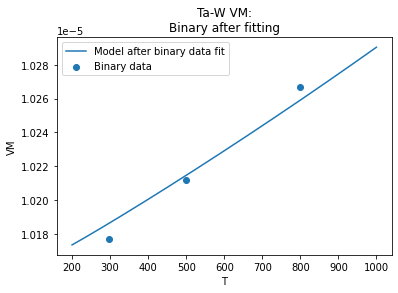

In [12]:
# VA binary fitting w/ temperature dependence

datasets = [
    # dummy dataset for 50/50 composition, eventually these should be real ESPEI datasets
    {
        "components": ["TA", "W"],
        "phases": ["BCC_A2"],
        "output": "V0_MIX",
        "values": [[[-1e-9]]],  # "fixed" value (absolute value from mix data with calphd reference state) extracted manually from above
        "conditions": {"T": 298.15, "P": 101325},
        "solver": {"sublattice_site_ratios": [1], "sublattice_configurations": [[["TA", "W"]]], "sublattice_occupancies": [[[0.5, 0.5]]]},
        "reference": "VASP (LLNL)",
        "bibtex": "UNPUBLISHED",
        "comment": "Brandon Bocklund DFT calculations. VASP, PBEsol, PAW 400 eV cutoff, 0.2 KSPACING",
        "tags": ["non-equilibrium-thermochemical", "LLNL-proprietary"]
    },
    # 1 point VA with temp dependence using mixing reference state
    {
        "components": ["TA", "W"],
        "phases": ["BCC_A2"],
        "output": "VM_MIX",
        "values": [[[-2e-8], [-2e-8], [-2e-8]]],
        "conditions": {"T": [298.15, 500, 800], "P": 101325},
        "solver": {"sublattice_site_ratios": [1], "sublattice_configurations": [[["TA", "W"]]], "sublattice_occupancies": [[[0.5, 0.5]]]},
        "reference": "VASP (LLNL)",
        "bibtex": "UNPUBLISHED",
        "comment": "Brandon Bocklund DFT calculations. VASP, PBEsol, PAW 400 eV cutoff, 0.2 KSPACING",
        "tags": ["non-equilibrium-thermochemical", "LLNL-proprietary"]
    },

]
dbf = Database("lu2005-volumes.tdb")
mod = Model(dbf, ["TA", "W"], "BCC_A2")

fit_model_x(molar_volume_fit_desc, datasets, dbf)  # parameter added automatically

# important, do not reload the database because we just added a new parameter!
mod = Model(dbf, ["TA", "W"], "BCC_A2")

TT = np.linspace(200, 1000, 1001)
x_TA = np.full_like(TT, 0.5)
x_W = 1-x_TA
x_TA_W_T = np.empty((TT.shape[-1], 3))
x_TA_W_T[:, 0] = x_TA
x_TA_W_T[:, 1] = x_W
x_TA_W_T[:, 2] = TT
func_VM_TA_W = lambdify([v.Y("BCC_A2", 0, "TA"), v.Y("BCC_A2", 0, "W"), v.T], [mod.VM])

print(x_TA_W_T)

plt.title("Ta-W VM:\nBinary after fitting")
plt.plot(TT, func_VM_TA_W(x_TA_W_T), label="Model after binary data fit")
data_3pt_VM_T = [
    -2.0e-8 + (func_VM_TA_W([1, 0, 298.15])*0.50 + func_VM_TA_W([0, 1, 298.15])*0.50),
    -2.0e-8 + (func_VM_TA_W([1, 0, 500])*0.50 + func_VM_TA_W([0, 1, 500])*0.50),
    -2.0e-8 + (func_VM_TA_W([1, 0, 800])*0.50 + func_VM_TA_W([0, 1, 800])*0.50),
]
# plt.scatter([0.5], data_1pt_VM, label='Binary data')
print("data_3pt_VM", data_3pt_VM_T)
plt.scatter([298.15, 500, 800], data_3pt_VM_T, label='Binary data')
plt.legend()
plt.xlabel("T")
plt.ylabel("VM")

## Unary fitting

Using Hf here so we can use the same TDB (there's no BCC data for Hf)

The data itself is fictious and based on Lu 2005 Al data.

In [13]:
datasets = [
    # Hf
    {
        "components": ["HF"],
        "phases": ["BCC_A2"],
        "conditions": {"P": 101315, "T": 298.15},
        "output": "V0",
        "solver": {"mode": "manual", "sublattice_site_ratios": [1], "sublattice_configurations": [[["HF"]]], "sublattice_occupancies": [[[1.0]]]},
        "values": [[[10.1092e-6]]],
        "reference": "VASP (LLNL)",
        "bibtex": "UNPUBLISHED",
        "comment": "Brandon Bocklund DFT calculations. VASP, PBEsol, PAW 400 eV cutoff, 0.2 KSPACING",
        "tags": ["non-equilibrium-thermochemical", "LLNL-proprietary"]
    },
    {
        "components": ["HF"],
        "phases": ["BCC_A2"],
        "conditions": {"P": 101315, "T": [274.5886654478977, 317.001828153565, 376.9652650822671, 455.94149908592334, 531.9926873857406, 602.1937842778796, 691.4076782449727, 850.8226691042048, 945.8866544789764, 1081.9012797074956, 1232.5411334552105]},
        "output": "VM",
        "solver": {"mode": "manual", "sublattice_site_ratios": [1], "sublattice_configurations": [[["HF"]]], "sublattice_occupancies": [[[1.0]]]},
        "values": [[[0.0000102595070150209], [0.000010282702483979838], [0.000010316942197393508], [0.00001036333044520191], [0.000010413028200193464], [0.000010467137734726063], [0.00001052456686435235], [0.000010640519998161758], [0.000010715609696499606], [0.000010824930365395328], [0.000010955226490404716]]],
        "reference": "VASP (LLNL)",
        "bibtex": "UNPUBLISHED",
        "comment": "Brandon Bocklund DFT calculations. VASP, PBEsol, PAW 400 eV cutoff, 0.2 KSPACING",
        "tags": ["non-equilibrium-thermochemical", "LLNL-proprietary"]
    }
]

# print(f"Model components (for verification): {mod.components}")

In [14]:
dbf = Database("lu2005-volumes.tdb")
mod_nofit = Model(dbf, ["HF"], "BCC_A2")
fit_model_x(molar_volume_fit_desc, datasets, dbf)


fitting_step <class 'espei.parameter_selection.fitting_steps.StepV0'>
Adding V0 parameters to BCC_A2 (('HF',),) order=0 1.01092e-05
fitting_step <class 'espei.parameter_selection.fitting_steps.StepLogVA'>
Adding VA parameters to BCC_A2 (('HF',),) order=0 4.91989219428596e-05*T
Adding VA parameters to BCC_A2 (('HF',),) order=0 1.30045505939515e-08*T**2


Pre-fit plot

Text(0, 0.5, 'VM')

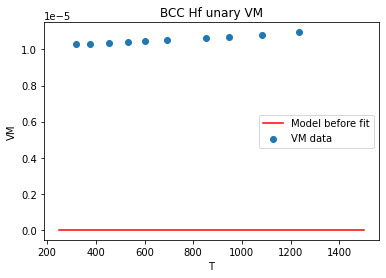

In [15]:

mod = Model(dbf, ["HF"], "BCC_A2")

pT = np.linspace(250, 1500, 1001)
func_HF_VM_nofit = lambdify([v.T], [mod_nofit.VM.subs({v.Y("BCC_A2", 0, "HF"): 1.0})])
func_HF_VM = lambdify([v.T], [mod.VM.subs({v.Y("BCC_A2", 0, "HF"): 1.0})])

# raw V0s from DFT
data_T = np.asarray(datasets[1]["conditions"]["T"])
data_VM = np.asarray(datasets[1]["values"]).squeeze()


plt.title("BCC Hf unary VM")
# plt.plot(pT, func_HF_VM(pT), label="Model after fit")
plt.plot(pT, func_HF_VM_nofit(pT), label="Model before fit", c='r')
plt.scatter(data_T, data_VM, label='VM data')
plt.legend()
plt.xlabel("T")
plt.ylabel("VM")
# plt.xlim(0, 1)

Text(0, 0.5, 'VM')

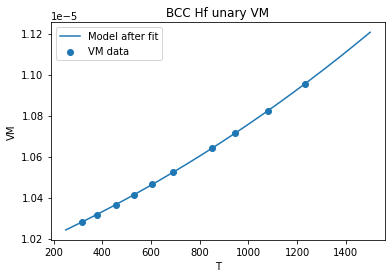

In [16]:
pT = np.linspace(250, 1500, 1001)
func_HF_VM_nofit = lambdify([v.T], [mod_nofit.VM.subs({v.Y("BCC_A2", 0, "HF"): 1.0})])
func_HF_VM = lambdify([v.T], [mod.VM.subs({v.Y("BCC_A2", 0, "HF"): 1.0})])

# raw V0s from DFT
data_T = np.asarray(datasets[1]["conditions"]["T"])
data_VM = np.asarray(datasets[1]["values"]).squeeze()


plt.title("BCC Hf unary VM")
plt.plot(pT, func_HF_VM(pT), label="Model after fit")
# plt.plot(pT, func_HF_VM_nofit(pT), label="Model before fit", c='r')
plt.scatter(data_T, data_VM, label='VM data')
plt.legend()
plt.xlabel("T")
plt.ylabel("VM")
# plt.xlim(0, 1)

## Binary fitting

### Basic 1 point data

In [17]:
datasets = [
    # dummy dataset for 50/50 composition, eventually these should be real ESPEI datasets
    {
        "components": ["TA", "W"],
        "phases": ["BCC_A2"],
        "output": "V0",
        "values": [[[1.00448925e-05]]],  # "fixed" value (absolute value from mix data with calphd reference state) extracted manually from above
        "conditions": {"T": 298.15, "P": 101325},
        "solver": {"sublattice_site_ratios": [1], "sublattice_configurations": [[["TA", "W"]]], "sublattice_occupancies": [[[0.5, 0.5]]]},
        "reference": "VASP (LLNL)",
        "bibtex": "UNPUBLISHED",
        "comment": "Brandon Bocklund DFT calculations. VASP, PBEsol, PAW 400 eV cutoff, 0.2 KSPACING",
        "tags": ["non-equilibrium-thermochemical", "LLNL-proprietary"]
    }
]
dbf = Database("lu2005-volumes.tdb")
mod = Model(dbf, ["TA", "W"], "BCC_A2")

print(f"Model components (for verification): {mod.components}")

Model components (for verification): [Species('TA', 'TA1'), Species('W', 'W1')]


In [18]:
fit_model_x(molar_volume_fit_desc, datasets, dbf)  # parameter added automatically

fitting_step <class 'espei.parameter_selection.fitting_steps.StepV0'>
Adding V0 parameters to BCC_A2 (('TA', 'W'),) order=0 -4.00189999999996e-07
fitting_step <class 'espei.parameter_selection.fitting_steps.StepLogVA'>
exiting with no data


[1.07870000e-05 1.04002492e-05 1.00448925e-05 9.76045653e-06
 9.50330000e-06]


(0.0, 1.0)

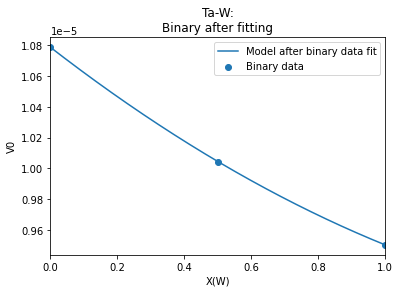

In [19]:
# important, do not reload the database because we just added a new parameter!
mod = Model(dbf, ["TA", "W"], "BCC_A2")

x_TA = np.linspace(0, 1, 1001)
x_W = 1-x_TA
x_TA_W = np.empty((x_TA.shape[-1], 2))
x_TA_W[:, 0] = x_TA
x_TA_W[:, 1] = x_W
func_V0_TA_W = lambdify([v.Y("BCC_A2", 0, "TA"), v.Y("BCC_A2", 0, "W")], [mod.V0])

v0_calphad = {  # these were extracted "by hand" from the print output above
    "CR": 7.0403e-06,
    "FE": 7.0079e-06,
    "MO": 9.3461e-06,
    "NB": 1.0752e-05,
    "TA": 1.0787e-05,
    "TI": 1.0592e-05,
    "V": 8.2481e-06,
    "W": 9.5033e-06,
    "ZR": 1.3812e-05,
}

# raw V0s from DFT
data_5pt_x_W = np.asarray([0, 0.25, 0.50, 0.75, 1.0])
data_5pt_V0 = np.asarray([1.0648e-05, 1.0287174212562773e-05, 9.957742546823015e-06, 9.699231530816361e-06, 9.468e-06])

# fix the reference state to match calphad
#                     V0             DFT V0_Ta * x_TA              +      DFT V0_W * x_W
# mixing reference state
data_5pt_V0_mix = data_5pt_V0 - (data_5pt_V0[0]*(1-data_5pt_x_W) + data_5pt_V0[-1]*(data_5pt_x_W))
# absolute values of Calphad unary + DFT_MIX binary
#                Calphad V0_Ta * x_TA               +       Calphad V0_W * x_W       +  DFT V0 MIX
data_5pt_V0_fix = v0_calphad["TA"]*(1-data_5pt_x_W) + v0_calphad["W"]*(data_5pt_x_W) + data_5pt_V0_mix
print(data_5pt_V0_fix)

data_1pt_x_W = data_5pt_x_W[[0,2,4]]
data_1pt_V0 = data_5pt_V0_fix[[0,2,4]]

plt.title("Ta-W:\nBinary after fitting")
plt.plot(x_W, func_V0_TA_W(x_TA_W), label="Model after binary data fit")
plt.scatter(data_1pt_x_W, data_1pt_V0, label='Binary data')
plt.legend()
plt.xlabel("X(W)")
plt.ylabel("V0")
plt.xlim(0, 1)

Repeat the above, but now use a real dataset

In [20]:
datasets = [
    {
        "components": ["TA", "W"],
        "phases": ["BCC_A2"],
        "conditions": {"P": 101315, "T": 298.15},
        "output": "V0",
        "solver": {"mode": "manual", "sublattice_site_ratios": [1], "sublattice_configurations": [[["TA", "W"]], [["TA", "W"]], [["TA", "W"]]], "sublattice_occupancies": [[[0.75, 0.25]], [[0.5, 0.5]], [[0.25, 0.75]]]},
        "values": [[[1.04002492e-05, 1.00448925e-05, 9.76045653e-06]]],  # fixed values from calculation w/ calphad refstate
        "reference": "VASP (LLNL)",
        "bibtex": "UNPUBLISHED",
        "comment": "Brandon Bocklund DFT calculations. VASP, PBEsol, PAW 400 eV cutoff, 0.2 KSPACING",
        "tags": ["non-equilibrium-thermochemical", "LLNL-proprietary"]
    }
]
dbf = Database("lu2005-volumes.tdb")
mod = Model(dbf, ["TA", "W"], "BCC_A2")

print(f"Model components (for verification): {mod.components}")

Model components (for verification): [Species('TA', 'TA1'), Species('W', 'W1')]


In [21]:
fit_model_x(molar_volume_fit_desc, datasets, dbf)

fitting_step <class 'espei.parameter_selection.fitting_steps.StepV0'>
Adding V0 parameters to BCC_A2 (('TA', 'W'),) order=0 -3.70688381176468e-07
fitting_step <class 'espei.parameter_selection.fitting_steps.StepLogVA'>
exiting with no data


mix [ 0.00000000e+00 -6.58257874e-08 -1.00257453e-07 -6.37684692e-08
  0.00000000e+00]
[1.07870000e-05 1.04002492e-05 1.00448925e-05 9.76045653e-06
 9.50330000e-06]


(0.0, 1.0)

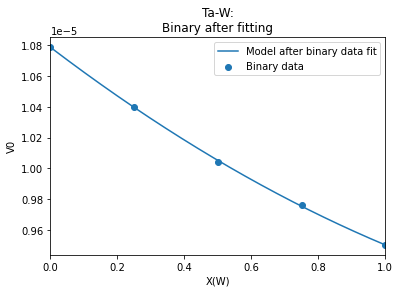

In [22]:
# important, do not reload the database because we just added a new parameter!
mod = Model(dbf, ["TA", "W"], "BCC_A2")

x_TA = np.linspace(0, 1, 1001)
x_W = 1-x_TA
x_TA_W = np.empty((x_TA.shape[-1], 2))
x_TA_W[:, 0] = x_TA
x_TA_W[:, 1] = x_W
func_V0_TA_W = lambdify([v.Y("BCC_A2", 0, "TA"), v.Y("BCC_A2", 0, "W")], [mod.V0])

v0_calphad = {  # these were extracted "by hand" from the print output above
    "CR": 7.0403e-06,
    "FE": 7.0079e-06,
    "MO": 9.3461e-06,
    "NB": 1.0752e-05,
    "TA": 1.0787e-05,
    "TI": 1.0592e-05,
    "V": 8.2481e-06,
    "W": 9.5033e-06,
    "ZR": 1.3812e-05,
}

# raw V0s from DFT
data_5pt_x_W = np.asarray([0, 0.25, 0.50, 0.75, 1.0])
data_5pt_V0 = np.asarray([1.0648e-05, 1.0287174212562773e-05, 9.957742546823015e-06, 9.699231530816361e-06, 9.468e-06])

# fix the reference state to match calphad
#                     V0             DFT V0_Ta * x_TA              +      DFT V0_W * x_W
# mixing reference state
data_5pt_V0_mix = data_5pt_V0 - (data_5pt_V0[0]*(1-data_5pt_x_W) + data_5pt_V0[-1]*(data_5pt_x_W))
print("mix", data_5pt_V0_mix)
# absolute values of Calphad unary + DFT_MIX binary
#                Calphad V0_Ta * x_TA               +       Calphad V0_W * x_W       +  DFT V0 MIX
data_5pt_V0_fix = v0_calphad["TA"]*(1-data_5pt_x_W) + v0_calphad["W"]*(data_5pt_x_W) + data_5pt_V0_mix
print(data_5pt_V0_fix)

plt.title("Ta-W:\nBinary after fitting")
plt.plot(x_W, func_V0_TA_W(x_TA_W), label="Model after binary data fit")
plt.scatter(data_5pt_x_W, data_5pt_V0_fix, label='Binary data')
plt.legend()
plt.xlabel("X(W)")
plt.ylabel("V0")
plt.xlim(0, 1)

## Mixing

In [23]:
datasets = [
    {
        "components": ["TA", "W"],
        "phases": ["BCC_A2"],
        "conditions": {"P": 101315, "T": 298.15},
        "output": "V0_MIX",
        "solver": {"mode": "manual", "sublattice_site_ratios": [1], "sublattice_configurations": [[["TA", "W"]], [["TA", "W"]], [["TA", "W"]]], "sublattice_occupancies": [[[0.75, 0.25]], [[0.5, 0.5]], [[0.25, 0.75]]]},
        "values": [[[-6.58257874e-08, -1.00257453e-07, -6.37684692e-08]]],
        "reference": "VASP (LLNL)",
        "bibtex": "UNPUBLISHED",
        "comment": "Brandon Bocklund DFT calculations. VASP, PBEsol, PAW 400 eV cutoff, 0.2 KSPACING",
        "tags": ["non-equilibrium-thermochemical", "LLNL-proprietary"]
    }
]
dbf = Database("lu2005-volumes.tdb")

fit_model_x(molar_volume_fit_desc, datasets, dbf)

fitting_step <class 'espei.parameter_selection.fitting_steps.StepV0'>
Adding V0 parameters to BCC_A2 (('TA', 'W'),) order=0 -3.71676509082354e-07
fitting_step <class 'espei.parameter_selection.fitting_steps.StepLogVA'>
exiting with no data


mix [ 0.00000000e+00 -6.58257874e-08 -1.00257453e-07 -6.37684692e-08
  0.00000000e+00]
[1.07870000e-05 1.04002492e-05 1.00448925e-05 9.76045653e-06
 9.50330000e-06]


(0.0, 1.0)

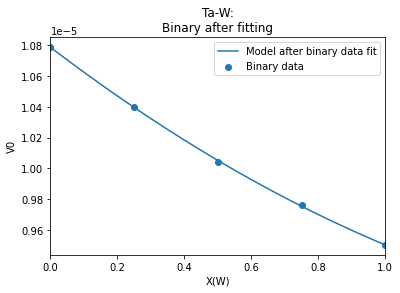

In [24]:
# important, do not reload the database because we just added a new parameter!
mod = Model(dbf, ["TA", "W"], "BCC_A2")

x_TA = np.linspace(0, 1, 1001)
x_W = 1-x_TA
x_TA_W = np.empty((x_TA.shape[-1], 2))
x_TA_W[:, 0] = x_TA
x_TA_W[:, 1] = x_W
func_V0_TA_W = lambdify([v.Y("BCC_A2", 0, "TA"), v.Y("BCC_A2", 0, "W")], [mod.V0])

v0_calphad = {  # these were extracted "by hand" from the print output above
    "CR": 7.0403e-06,
    "FE": 7.0079e-06,
    "MO": 9.3461e-06,
    "NB": 1.0752e-05,
    "TA": 1.0787e-05,
    "TI": 1.0592e-05,
    "V": 8.2481e-06,
    "W": 9.5033e-06,
    "ZR": 1.3812e-05,
}

# raw V0s from DFT
data_5pt_x_W = np.asarray([0, 0.25, 0.50, 0.75, 1.0])
data_5pt_V0 = np.asarray([1.0648e-05, 1.0287174212562773e-05, 9.957742546823015e-06, 9.699231530816361e-06, 9.468e-06])

# fix the reference state to match calphad
#                     V0             DFT V0_Ta * x_TA              +      DFT V0_W * x_W
# mixing reference state
data_5pt_V0_mix = data_5pt_V0 - (data_5pt_V0[0]*(1-data_5pt_x_W) + data_5pt_V0[-1]*(data_5pt_x_W))
print("mix", data_5pt_V0_mix)
# absolute values of Calphad unary + DFT_MIX binary
#                Calphad V0_Ta * x_TA               +       Calphad V0_W * x_W       +  DFT V0 MIX
data_5pt_V0_fix = v0_calphad["TA"]*(1-data_5pt_x_W) + v0_calphad["W"]*(data_5pt_x_W) + data_5pt_V0_mix
print(data_5pt_V0_fix)

plt.title("Ta-W:\nBinary after fitting")
plt.plot(x_W, func_V0_TA_W(x_TA_W), label="Model after binary data fit")
plt.scatter(data_5pt_x_W, data_5pt_V0_fix, label='Binary data')
plt.legend()
plt.xlabel("X(W)")
plt.ylabel("V0")
plt.xlim(0, 1)

# Ternary

start with binary fitting

In [25]:
datasets = [
    {
        "components": ["TA", "W"],
        "phases": ["BCC_A2"],
        "conditions": {"P": 101315, "T": 298.15},
        "output": "V0_MIX",
        "solver": {"mode": "manual", "sublattice_site_ratios": [1], "sublattice_configurations": [[["TA", "W"]], [["TA", "W"]], [["TA", "W"]]], "sublattice_occupancies": [[[0.75, 0.25]], [[0.5, 0.5]], [[0.25, 0.75]]]},
        "values": [[[-6.58257874e-08, -1.00257453e-07, -6.37684692e-08]]],
        "reference": "VASP (LLNL)",
        "bibtex": "UNPUBLISHED",
        "comment": "Brandon Bocklund DFT calculations. VASP, PBEsol, PAW 400 eV cutoff, 0.2 KSPACING",
        "tags": ["non-equilibrium-thermochemical", "LLNL-proprietary"]
    }
]
dbf = Database("lu2005-volumes.tdb")

fit_model_x(molar_volume_fit_desc, datasets, dbf)

fitting_step <class 'espei.parameter_selection.fitting_steps.StepV0'>
Adding V0 parameters to BCC_A2 (('TA', 'W'),) order=0 -3.71676509082354e-07
fitting_step <class 'espei.parameter_selection.fitting_steps.StepLogVA'>
exiting with no data


mix [ 0.00000000e+00 -6.58257874e-08 -1.00257453e-07 -6.37684692e-08
  0.00000000e+00]
[1.07870000e-05 1.04002492e-05 1.00448925e-05 9.76045653e-06
 9.50330000e-06]


(0.0, 1.0)

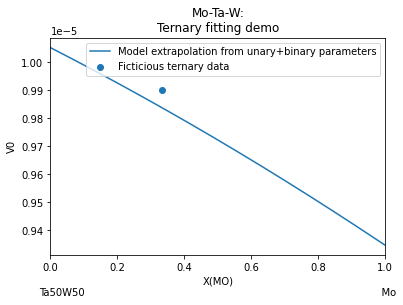

In [26]:
# important, do not reload the database because we just added a new parameter!
mod = Model(dbf, ["TA", "MO", "W"], "BCC_A2")

x_MO = np.linspace(0, 1, 1001)
x_TA = (1 - x_MO) / 2
x_W = (1 - x_MO) / 2
x_MO_TA_W = np.empty((x_MO.shape[-1], 3))
x_MO_TA_W[:, 0] = x_MO
x_MO_TA_W[:, 1] = x_TA
x_MO_TA_W[:, 2] = x_W
func_V0_MO_TA_W = lambdify([v.Y("BCC_A2", 0, "MO"), v.Y("BCC_A2", 0, "TA"), v.Y("BCC_A2", 0, "W")], [mod.V0])

v0_calphad = {  # these were extracted "by hand" from the print output above
    "CR": 7.0403e-06,
    "FE": 7.0079e-06,
    "MO": 9.3461e-06,
    "NB": 1.0752e-05,
    "TA": 1.0787e-05,
    "TI": 1.0592e-05,
    "V": 8.2481e-06,
    "W": 9.5033e-06,
    "ZR": 1.3812e-05,
}

# raw V0s from DFT
data_5pt_x_W = np.asarray([0, 0.25, 0.50, 0.75, 1.0])
data_5pt_V0 = np.asarray([1.0648e-05, 1.0287174212562773e-05, 9.957742546823015e-06, 9.699231530816361e-06, 9.468e-06])

# fix the reference state to match calphad
#                     V0             DFT V0_Ta * x_TA              +      DFT V0_W * x_W
# mixing reference state
data_5pt_V0_mix = data_5pt_V0 - (data_5pt_V0[0]*(1-data_5pt_x_W) + data_5pt_V0[-1]*(data_5pt_x_W))
print("mix", data_5pt_V0_mix)
# absolute values of Calphad unary + DFT_MIX binary
#                Calphad V0_Ta * x_TA               +       Calphad V0_W * x_W       +  DFT V0 MIX
data_5pt_V0_fix = v0_calphad["TA"]*(1-data_5pt_x_W) + v0_calphad["W"]*(data_5pt_x_W) + data_5pt_V0_mix
print(data_5pt_V0_fix)

plt.title("Mo-Ta-W:\nTernary fitting demo")
plt.plot(x_MO, func_V0_MO_TA_W(x_MO_TA_W), label="Model extrapolation from unary+binary parameters")
plt.scatter(0.333, 0.99e-5, label='Ficticious ternary data')
plt.legend(loc="upper right")
plt.xlabel(f"X(MO)\nTa50W50{'':>95}Mo")
plt.ylabel("V0")
plt.xlim(0, 1)

## Fit

In [27]:
datasets = [
    {
        "components": ["MO", "TA", "W"],
        "phases": ["BCC_A2"],
        "conditions": {"P": 101315, "T": 298.15},
        "output": "V0",
        "solver": {"mode": "manual", "sublattice_site_ratios": [1], "sublattice_configurations": [[["MO", "TA", "W"]]], "sublattice_occupancies": [[[0.333333, 0.333333, 0.333333]]]},
        "values": [[[0.99e-5]]],  # ficitious value
        "reference": "VASP (LLNL)",
        "bibtex": "UNPUBLISHED",
        "comment": "Brandon Bocklund DFT calculations. VASP, PBEsol, PAW 400 eV cutoff, 0.2 KSPACING",
        "tags": ["non-equilibrium-thermochemical", "LLNL-proprietary"]
    }
]
mod = Model(dbf, ["MO", "TA", "W"], "BCC_A2")

print(f"Model components (for verification): {mod.components}")

Model components (for verification): [Species('MO', 'MO1'), Species('TA', 'TA1'), Species('W', 'W1')]


In [28]:
fit_model_x(molar_volume_fit_desc, datasets, dbf)

fitting_step <class 'espei.parameter_selection.fitting_steps.StepV0'>
Adding V0 parameters to BCC_A2 (('MO', 'TA', 'W'),) order=0 1.69138740387226e-06
fitting_step <class 'espei.parameter_selection.fitting_steps.StepLogVA'>
exiting with no data


mix [ 0.00000000e+00 -6.58257874e-08 -1.00257453e-07 -6.37684692e-08
  0.00000000e+00]
[1.07870000e-05 1.04002492e-05 1.00448925e-05 9.76045653e-06
 9.50330000e-06]


(0.0, 1.0)

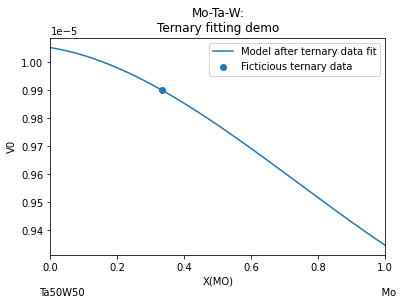

In [29]:
# important, do not reload the database because we just added a new parameter!
mod = Model(dbf, ["TA", "MO", "W"], "BCC_A2")

x_MO = np.linspace(0, 1, 1001)
x_TA = (1 - x_MO) / 2
x_W = (1 - x_MO) / 2
x_MO_TA_W = np.empty((x_MO.shape[-1], 3))
x_MO_TA_W[:, 0] = x_MO
x_MO_TA_W[:, 1] = x_TA
x_MO_TA_W[:, 2] = x_W
func_V0_MO_TA_W = lambdify([v.Y("BCC_A2", 0, "MO"), v.Y("BCC_A2", 0, "TA"), v.Y("BCC_A2", 0, "W")], [mod.V0])

v0_calphad = {  # these were extracted "by hand" from the print output above
    "CR": 7.0403e-06,
    "FE": 7.0079e-06,
    "MO": 9.3461e-06,
    "NB": 1.0752e-05,
    "TA": 1.0787e-05,
    "TI": 1.0592e-05,
    "V": 8.2481e-06,
    "W": 9.5033e-06,
    "ZR": 1.3812e-05,
}

# raw V0s from DFT
data_5pt_x_W = np.asarray([0, 0.25, 0.50, 0.75, 1.0])
data_5pt_V0 = np.asarray([1.0648e-05, 1.0287174212562773e-05, 9.957742546823015e-06, 9.699231530816361e-06, 9.468e-06])

# fix the reference state to match calphad
#                     V0             DFT V0_Ta * x_TA              +      DFT V0_W * x_W
# mixing reference state
data_5pt_V0_mix = data_5pt_V0 - (data_5pt_V0[0]*(1-data_5pt_x_W) + data_5pt_V0[-1]*(data_5pt_x_W))
print("mix", data_5pt_V0_mix)
# absolute values of Calphad unary + DFT_MIX binary
#                Calphad V0_Ta * x_TA               +       Calphad V0_W * x_W       +  DFT V0 MIX
data_5pt_V0_fix = v0_calphad["TA"]*(1-data_5pt_x_W) + v0_calphad["W"]*(data_5pt_x_W) + data_5pt_V0_mix
print(data_5pt_V0_fix)

plt.title("Mo-Ta-W:\nTernary fitting demo")
plt.plot(x_MO, func_V0_MO_TA_W(x_MO_TA_W), label="Model after ternary data fit")
plt.scatter(0.333, 0.99e-5, label='Ficticious ternary data')
plt.legend(loc="upper right")
plt.xlabel(f"X(MO)\nTa50W50{'':>95}Mo")
plt.ylabel("V0")
plt.xlim(0, 1)